In [1]:
import numpy as np
import pandas as pd
from pathlib import Path

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
        
input_path = Path('/kaggle/input/tabular-playground-series-jan-2021/')

/kaggle/input/tabular-playground-series-jan-2021/sample_submission.csv
/kaggle/input/tabular-playground-series-jan-2021/train.csv
/kaggle/input/tabular-playground-series-jan-2021/test.csv


# Read in the data files

In [2]:
train = pd.read_csv(input_path / 'train.csv', index_col='id')
display(train.head())

,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,target
id,,,,,,,,,,,,,,,
1,0.670390,0.811300,0.643968,0.291791,0.284117,0.855953,0.890700,0.285542,0.558245,0.779418,0.921832,0.866772,0.878733,0.305411,7.243043
3,0.388053,0.621104,0.686102,0.501149,0.643790,0.449805,0.510824,0.580748,0.418335,0.432632,0.439872,0.434971,0.369957,0.369484,8.203331
4,0.834950,0.227436,0.301584,0.293408,0.606839,0.829175,0.506143,0.558771,0.587603,0.823312,0.567007,0.677708,0.882938,0.303047,7.776091
5,0.820708,0.160155,0.546887,0.726104,0.282444,0.785108,0.752758,0.823267,0.574466,0.580843,0.769594,0.818143,0.914281,0.279528,6.957716
8,0.935278,0.421235,0.303801,0.880214,0.665610,0.830131,0.487113,0.604157,0.874658,0.863427,0.983575,0.900464,0.935918,0.435772,7.951046


In [3]:
test = pd.read_csv(input_path / 'test.csv', index_col='id')
display(test.head())

,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14
id,,,,,,,,,,,,,,
0,0.353600,0.738780,0.600939,0.293377,0.285691,0.458006,0.620704,0.422249,0.369203,0.435727,0.550540,0.699134,0.286864,0.364515
2,0.907222,0.189756,0.215531,0.869915,0.301333,0.528958,0.390351,0.521112,0.794779,0.798580,0.446475,0.449037,0.916964,0.513002
6,0.179287,0.355353,0.623972,0.437812,0.282476,0.320826,0.386789,0.776422,0.222268,0.229102,0.211913,0.222651,0.327164,0.827941
7,0.359385,0.181049,0.551368,0.206386,0.280763,0.482076,0.506677,0.362793,0.379737,0.345686,0.445276,0.518485,0.299028,0.598166
10,0.335791,0.682607,0.676481,0.219465,0.282861,0.581721,0.748639,0.350158,0.448915,0.506878,0.817721,0.805895,0.790591,0.249275


In [4]:
submission = pd.read_csv(input_path / 'sample_submission.csv', index_col='id')
display(submission.head())

,target
id,
0,0.5
2,0.5
6,0.5
7,0.5
10,0.5


## Pull out the target, and make a validation split

In [5]:
target = train.pop('target')
X_train, X_test, y_train, y_test = train_test_split(train, target, train_size=0.60)

# How well can we do with a completely naive model?

We'll want any of our models to do (hopefully much!) better than this.

In [6]:
# Let's get a benchmark score
model_dummy = DummyRegressor(strategy='median')
model_dummy.fit(X_train, y_train)
y_dummy = model_dummy.predict(X_test)
score_dummy = mean_squared_error(y_test, y_dummy, squared=False)
print(f'{score_dummy:0.5f}') # 0.54118

0.73487


# Simple Linear Regression

A simple linear regression doesn't do better than our dummy regressor!

In [7]:
# Simple Linear Regression
model_simple_linear = LinearRegression(fit_intercept=False) # data is not centered, don't fit intercept
model_simple_linear.fit(X_train, y_train)
y_simple_linear = model_simple_linear.predict(X_test)
score_simple_linear = mean_squared_error(y_test, y_simple_linear, squared=False)
print(f'{score_simple_linear:0.5f}')

1.33039


# This seems slow and repetitive. Can we automate it a bit?

In [8]:
def plot_results(name, y, yhat, num_to_plot=10000, lims=(0,12), figsize=(6,6)):
    plt.figure(figsize=figsize)
    score = mean_squared_error(y, yhat, squared=False)
    plt.scatter(y[:num_to_plot], yhat[:num_to_plot])
    plt.plot(lims, lims)
    plt.ylim(lims)
    plt.xlim(lims)
    plt.title(f'{name}: {score:0.5f}', fontsize=18)
    plt.show()

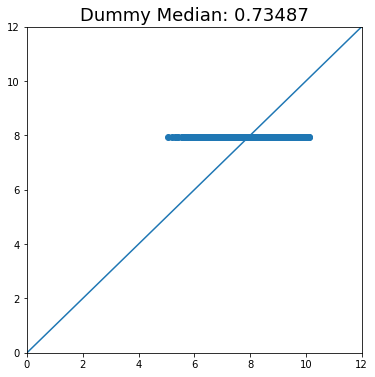

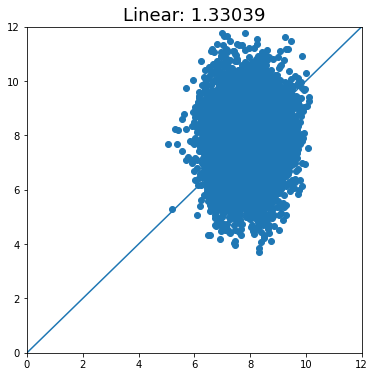

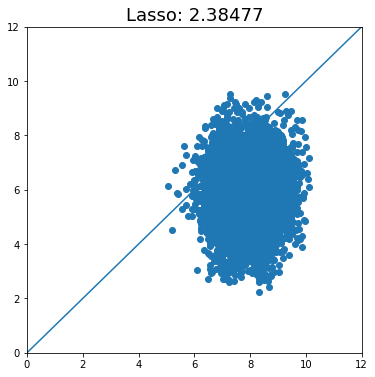

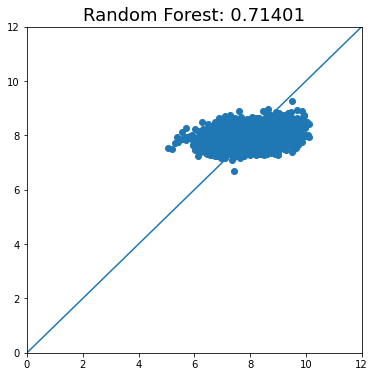

In [9]:
model_names = ["Dummy Median", "Linear",  "Lasso", "Random Forest"]

models = [
    DummyRegressor(strategy='median'),
    LinearRegression(fit_intercept=False),
    Lasso(fit_intercept=False),
    RandomForestRegressor(n_estimators=50, n_jobs=-1)]

for name, model in zip(model_names, models):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    plot_results(name, y_test, y_pred)

# It look like RandomForest did the best. Let's train it on all the data and make a submission!

In [10]:
model = RandomForestRegressor(n_estimators=50, n_jobs=-1)
model.fit(train, target)
submission['target'] = model.predict(test)
submission.to_csv('random_forest.csv')